In [111]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent 
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

%load_ext autoreload
%autoreload 2

Added to path: /Users/elshaday/DEV/10Academy/intelligent-complaint-analysis-week7
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import src.data.loader as loader
import src.data.preprocessor as preprocessor
from scripts.constants import Columns, Processed_Columns, product_categories
from tabulate import tabulate
import matplotlib.pyplot as plt

In [3]:
data_loader = loader.DataLoader()
complaints_df = data_loader.load_from_csv()

Loaded ../data/raw/complaints.csv to Dataframe!


In [155]:
complaints_df_sample = complaints_df.sample(n=1000000)

In [156]:
print("Data Description")
print(tabulate(complaints_df_sample.describe(include="all"), tablefmt="psql"))

Data Description
+--------+------------+-----------------------------------------------------+------------------+--------------------------------------+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+---------------+--------+--------+---------------+----------------------+---------+------------+-------------------------+---------+-------+---------------+
| count  | 1000000    | 1000000                                             | 975513           | 999999                 

#### 1. Distribution of products

In [157]:
product_count = complaints_df_sample[Columns.PRODUCT.value].value_counts()
print(product_count)

Product
Credit reporting or other personal consumer reports                             501741
Credit reporting, credit repair services, or other personal consumer reports    226074
Debt collection                                                                  83558
Mortgage                                                                         44311
Checking or savings account                                                      30106
Credit card                                                                      23718
Credit card or prepaid card                                                      21511
Money transfer, virtual currency, or money service                               15102
Credit reporting                                                                 14541
Student loan                                                                     11432
Bank account or service                                                           8947
Vehicle loan or lease              

#### 2. Distribution of complaints across products

In [158]:
grouped_by_product = (
    complaints_df_sample.groupby(Columns.PRODUCT.value)[Columns.COMPLAINT.value]
    .count()
    .sort_values(ascending=False)
)
print(grouped_by_product)

Product
Credit reporting or other personal consumer reports                             113148
Credit reporting, credit repair services, or other personal consumer reports     84492
Debt collection                                                                  35069
Checking or savings account                                                      14349
Mortgage                                                                         13727
Credit card or prepaid card                                                      11282
Money transfer, virtual currency, or money service                               10039
Credit card                                                                       8391
Student loan                                                                      5563
Vehicle loan or lease                                                             4036
Credit reporting                                                                  3175
Payday loan, title loan, or persona

#### 3. Number of complaints with and without narratives

In [159]:
number_of_complaints_with_narratives = complaints_df_sample[Columns.COMPLAINT.value].notna().sum()
number_of_complaints_without_narratives = (
    complaints_df_sample[Columns.COMPLAINT.value].isna().sum()
)

print(f"Number of complaints with narratives:", number_of_complaints_with_narratives)
print(f"Number of complaints without narratives:", number_of_complaints_without_narratives)

Number of complaints with narratives: 309978
Number of complaints without narratives: 690022


#### 4. Preprocess Data

In [160]:
# Preprocess Data
data_preprocessor = preprocessor.DataPreprocessor(complaints_df_sample)
working_df = data_preprocessor.get_processed_data()

Dropped 690022 rows containing null narratives.
New shape: (309978, 18)


#### 5. Customer narrative length analysis

In [161]:
working_df[Processed_Columns.WORD_COUNT.value] = (
    working_df[Columns.COMPLAINT.value].str.split().str.len()
)

print(tabulate(working_df[[Columns.COMPLAINT.value, Processed_Columns.WORD_COUNT.value]].head(), headers="keys", tablefmt="psql"))

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### 6. Customer narrative visualization

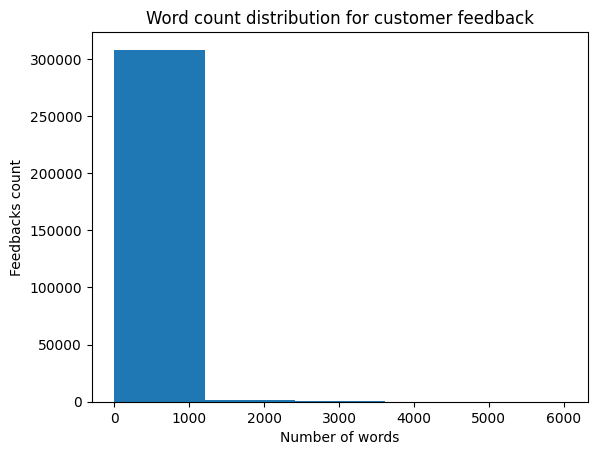

In [162]:
plt.hist(working_df[Processed_Columns.WORD_COUNT.value], bins=5)
plt.title("Word count distribution for customer feedback")
plt.xlabel("Number of words")
plt.ylabel("Feedbacks count")
plt.show()

#### 7. Include only records for the five specified products 

In [163]:
subset_df = data_preprocessor.subset_product_categories(working_df)
print(subset_df[Columns.PRODUCT.value].value_counts())


Product
Credit card                                  8391
Payday loan, title loan, or personal loan    1747
Money transfers                               160
Name: count, dtype: int64


#### 8. Clean Customer Feedback column

In [164]:
clean_df = data_preprocessor.clean_and_normalize_customer_feedback(
    subset_df,
    Columns.COMPLAINT.value,
    Processed_Columns.CLEANED_COMPLAINT.value,
    Processed_Columns.NORMALIZED_COMPLAINT.value,
)
print(clean_df[Columns.COMPLAINT.value].head(10))

/Users/elshaday/DEV/10Academy/intelligent-complaint-analysis-week7/src/data/preprocessor.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cleaned_col] = df[col].apply(clean_text)


9235424    XXXX  XXXX XXXX XXXX XXXX, PA XXXX Dear sir, I...
8932039    I've always ensured timely payments on this ac...
9319828    American Express has continuously mishandled a...
6171437    My account was closed with no warning. They wo...
8916724    Dear Sir/Madam, I am writing to dispute a coll...
2444942    I am writing to bring to your attention a seri...
7081846    XXXX PayPal ran an unauthorized hard credit ch...
6077711    In XX/XX/XXXX I took a loan out for approximat...
6458647    XXXX/XXXX/XXXX my personal info was used to ge...
7523087    I am trying to transfer a balance from my Sync...
Name: Consumer complaint narrative, dtype: object


/Users/elshaday/DEV/10Academy/intelligent-complaint-analysis-week7/src/data/preprocessor.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalized_col] = df[col].apply(tokenize_and_lemmatize)


#### 9. Save the cleaned data to a new CSV file

In [165]:
print(clean_df.shape)
data_loader.save_to_csv(clean_df)

(10298, 21)
Saved dataframe to ../data/processed/complaints_clean.csv
